<a href="https://colab.research.google.com/github/buthaina279/DS_Capstone_NLP/blob/main/ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
# Import Libraries

from textblob import TextBlob
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import os
import nltk
from google.colab import drive  
#import pycountry
import re
import string

from wordcloud import WordCloud, STOPWORDS
from PIL import Image
from nltk.sentiment.vader import SentimentIntensityAnalyzer
#from langdetect import detect
from nltk.stem import SnowballStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import itertools
from wordcloud import WordCloud,STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
import re
import nltk
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn import metrics

from sklearn.metrics import accuracy_score, classification_report

from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression


In [2]:
# Connect Google Drive to Colab
drive.mount('/content/gdrive')
# Create a variable to store the data path on your drive
path = './gdrive/My Drive/datasets/twitter_analysis'

Mounted at /content/gdrive


In [50]:
airline = pd.read_csv("./gdrive/My Drive/datasets/twitter_analysis/airline_classified.csv")

In [48]:
airline.sample(5)

,Unnamed: 0,Unnamed: 0.1,tweet_id,created_at,text,likes,retweeted,location,language,airline,nonstop_documents,sentiment_confidence,polarity,sentiment
921,921,2513,1322959002947473409,2020-11-01 17:49:40,dear guest there is no flight from india to s...,0,False,Saudi Arabia,en,Saudi_airlines,dear guest flight india saudi arabia time kin...,0.9,0.6,Positive
896,896,2460,1323266288681144320,2020-11-02 14:10:42,wasik dear guest there is no flight from india...,0,False,Saudi Arabia,en,Saudi_airlines,wasik dear guest flight india saudi arabia tim...,0.9,0.6,Positive
891,891,2454,1323273091334705152,2020-11-02 14:37:44,dear guest there is no flight from india to s...,0,False,Saudi Arabia,en,Saudi_airlines,dear guest flight india saudi arabia time kin...,0.9,0.6,Positive
1268,1268,3101,1320947510081474566,2020-10-27 04:36:43,port dear guest please follow up via our websi...,0,False,Saudi Arabia,en,Saudi_airlines,port dear guest please follow via website flig...,0.4,0.4,Positive
1112,1112,2806,1322021890215546880,2020-10-30 03:45:55,dear guest there is no flight from india to s...,0,False,Saudi Arabia,en,Saudi_airlines,dear guest flight india saudi arabia time,0.0,0.0,Neutral


#EDA

In [7]:
airline.shape

(1569, 14)

In [9]:
airline.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'tweet_id', 'created_at', 'text', 'likes',
       'retweeted', 'location', 'language', 'airline', 'nonstop_documents',
       'sentiment_confidence', 'polarity', 'sentiment'],
      dtype='object')

In [10]:
#Check for missing values
100*airline.isna().sum()/len(airline)

Unnamed: 0              0.0
Unnamed: 0.1            0.0
tweet_id                0.0
created_at              0.0
text                    0.0
likes                   0.0
retweeted               0.0
location                0.0
language                0.0
airline                 0.0
nonstop_documents       0.0
sentiment_confidence    0.0
polarity                0.0
sentiment               0.0
dtype: float64

In [11]:
# Data balance
def createPieChartFor(t_df):
    Lst = 100*t_df.value_counts()/len(t_df)
    
    # set data for pie chart
    labels = t_df.value_counts().index.values
    sizes =  Lst 
    
    # set labels
    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, labels=labels, autopct='%1.2f%%', shadow=True, startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()

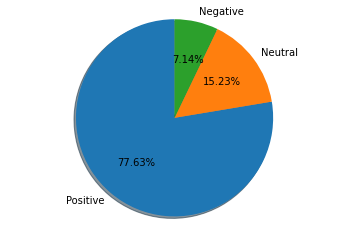

In [13]:
createPieChartFor(airline.sentiment)

Most of the sentiment are positive and less than 8% is for the negative sentiment. Therefore, thte majority of people are feeling satsfied.

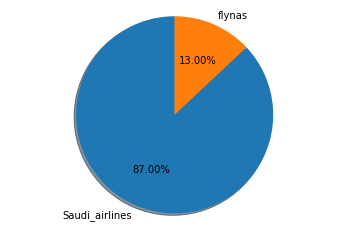

In [14]:
createPieChartFor(airline.airline)

The plot illustrated that the dominant airline in Saudi Arabia is Saudia Airlines with 87%. However, in fact, this case is more likely due to the less English tweets for flynas which make it only 13%.

now check total tweets for each of the airlines and


how many of these tweets per airline are negative, positive and neutral

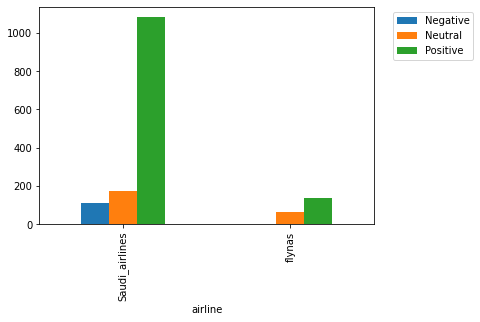

In [15]:
airline_sentiment_df = airline.groupby(['airline','sentiment']).sentiment.count().unstack()
airline_sentiment_df.plot(kind='bar')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

The bar chart show us that in the both airlines the positive sentiment is more than negative and neutral sentiment with roughly 1100 tweets for Saudia Airlines and almost 180 tweets for flynas.

In [85]:
def createWrdCloudForSentiment(sentiment):
    temp_df = airline[airline.sentiment==sentiment]
    words = " ".join(temp_df.nonstop_documents)
    
    wrdcld = WordCloud(background_color='black',
                      width=1500,
                      height=1000).generate(words)
    plt.figure(figsize=(10,10))
    plt.imshow(wrdcld)
    plt.axis('off')
    plt.show

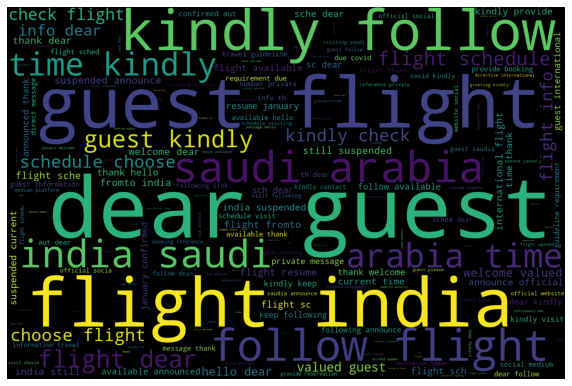

In [86]:
createWrdCloudForSentiment('Positive')

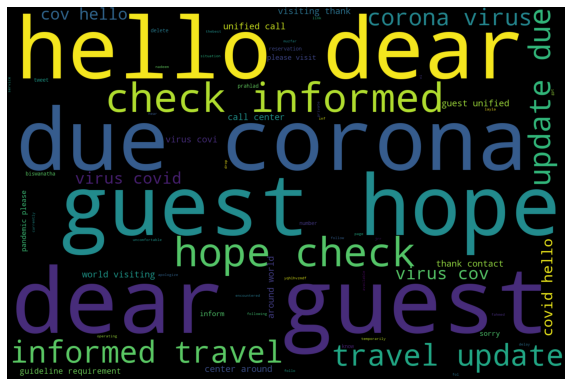

In [87]:
createWrdCloudForSentiment('Negative')

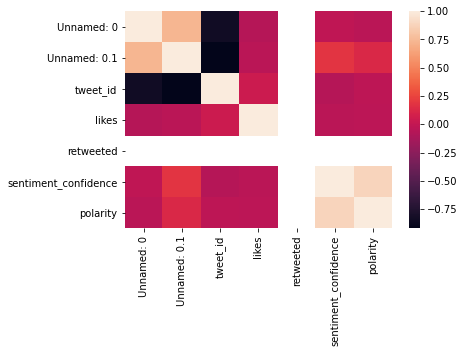

In [49]:
sns.heatmap(airline.corr())
plt.show()

The correlation plot demonstrates that **retweeted** varible is **highly correlated** with all other variables. Thus, we are going to **delete** it. 

In [60]:
airline = airline.drop(['retweeted'], axis=1)

In [61]:
airline.sample(5)

,Unnamed: 0,Unnamed: 0.1,tweet_id,created_at,text,likes,location,language,airline,nonstop_documents,sentiment_confidence,sentiment
374,374,1288,1328913002033262592,2020-11-18 04:08:44,dear guest according to the directives reside...,2,Saudi Arabia,en,Saudi_airlines,dear guest according directive resident exit ...,0.0,Neutral
1258,1258,3076,1321046048819785729,2020-10-27 11:08:16,dear guest saudia will resume the flight to i...,22,Saudi Arabia,en,Saudi_airlines,dear guest saudia resume flight india fir nov...,0.0,Neutral
1223,1223,3030,1321106339494567939,2020-10-27 15:07:50,dear guest kindly check the flights schedule ...,0,Saudi Arabia,en,Saudi_airlines,dear guest kindly check flight schedule choos...,0.9,Positive
1563,1563,3185,1311239454955376640,2020-09-30 09:40:22,hello dear follow us we will be announce when...,0,Saudi Arabia,en,flynas,hello dear follow u announce flight resume thank,0.0,Neutral
1512,1512,2458,1315912258220961794,2020-10-13 07:08:25,hello dear kindly contact with the relevant a...,0,Saudi Arabia,en,flynas,hello dear kindly contact relevant authority ...,0.9,Positive


#**Preproccesing**

#Delete uninformative variables

In [62]:
airline = airline.drop(['Unnamed: 0','Unnamed: 0.1', 'text', 'language', 'created_at'], axis=1)

In [63]:
airline.sample(5)

,tweet_id,likes,location,airline,nonstop_documents,sentiment_confidence,sentiment
1530,1314165385235750912,1,Saudi Arabia,flynas,hello dear please check competent authority,0.666667,Positive
1022,1322551270637527042,0,Saudi Arabia,Saudi_airlines,dear guest flight india saudi arabia time kin...,0.900000,Positive
572,1326240214252195841,0,Saudi Arabia,Saudi_airlines,dear guest flight india saudi arabia time kin...,0.900000,Positive
1000,1322577651861770244,1,Saudi Arabia,Saudi_airlines,dear guest kindly check flight schedule choos...,0.900000,Positive
732,1324733422942720000,0,Saudi Arabia,Saudi_airlines,dear guest flight india saudi arabia time kin...,0.900000,Positive


#Devide the dataset into predictors and target

In [116]:
X = airline.iloc[:,:-1].values #all predictor columns without the target
y = airline.iloc[:,-1].values #last column (target)

#Encoding the independent variables

- retweeted
- location
- airline

In [117]:
ct = ColumnTransformer(transformers=[('encoder',
                                      OneHotEncoder(), 
                                      [2,3,4])], 
                                      remainder='passthrough')

X = ct.fit_transform(X)
X = np.array(X)
print(X)


  (0, 0)	1.0
  (0, 1)	1.0
  (0, 31)	1.0
  (0, 396)	1.3367285692722627e+18
  (0, 398)	0.9
  (1, 0)	1.0
  (1, 1)	1.0
  (1, 31)	1.0
  (1, 396)	1.3367193545373696e+18
  (1, 398)	0.9
  (2, 0)	1.0
  (2, 1)	1.0
  (2, 211)	1.0
  (2, 396)	1.336711502087254e+18
  (3, 0)	1.0
  (3, 1)	1.0
  (3, 131)	1.0
  (3, 396)	1.336705261340332e+18
  (3, 398)	0.6375
  (4, 0)	1.0
  (4, 1)	1.0
  (4, 32)	1.0
  (4, 396)	1.3366930422254838e+18
  (4, 398)	0.9
  (5, 0)	1.0
  :	:
  (1563, 396)	1.3112394549553766e+18
  (1564, 0)	1.0
  (1564, 2)	1.0
  (1564, 197)	1.0
  (1564, 396)	1.3112326330583409e+18
  (1565, 0)	1.0
  (1565, 2)	1.0
  (1565, 330)	1.0
  (1565, 396)	1.311186912451928e+18
  (1565, 398)	0.375
  (1566, 0)	1.0
  (1566, 2)	1.0
  (1566, 202)	1.0
  (1566, 396)	1.310945894389424e+18
  (1566, 398)	0.375
  (1567, 0)	1.0
  (1567, 2)	1.0
  (1567, 140)	1.0
  (1567, 396)	1.310905077364908e+18
  (1567, 398)	0.6375
  (1568, 0)	1.0
  (1568, 2)	1.0
  (1568, 138)	1.0
  (1568, 396)	1.3108723485732618e+18
  (1568, 398)	0.63

#Encoding the dependent variables


In [118]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)
print(y)

[2 2 1 ... 1 2 2]


#Dealing with datetime

In [ ]:
from datetime import datetime
for date in saudia_airlines.iloc[:,0]:
  datetime_object = datetime.strptime(date, '%Y-%m-%d %H:%M:%S')

In [ ]:
saudia_airlines.iloc[:,0]

0       2020-12-06 01:21:16
1       2020-12-05 21:37:29
2       2020-12-05 21:24:45
3       2020-12-05 20:36:03
4       2020-12-05 20:07:02
               ...         
1459    2020-10-25 13:13:11
1460    2020-10-25 13:13:05
1461    2020-10-25 13:13:00
1462    2020-10-25 12:18:46
1463    2020-10-25 12:13:41
Name: created_at, Length: 1464, dtype: object

#Extracting Features from Cleaned Tweets

https://www.analyticsvidhya.com/blog/2018/07/hands-on-sentiment-analysis-dataset-python/



CounterVectorizer method needs a list of strings and not tokens.*italicized text*

#Model calibration

https://towardsdatascience.com/classifier-calibration-7d0be1e05452

Let us now plot the Kernel Density Estimation for the two classifiers.

In [ ]:
plt.figure(figsize=(10,6))
sns.kdeplot(probs_lgr, label='Logistic regression')
sns.kdeplot(preds_svc, label='SVM')
plt.title("Probability Density Plot for 2 Classifiers")
plt.show()

let us check the AUC-ROC curve for the two binary classifiers, but this time using the probabilities we calculated for the SVM.

ValueError: ignored

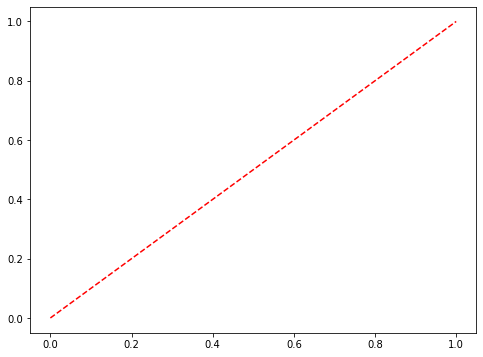

In [112]:
from sklearn import metrics


plt.figure(figsize=(8,6))
plt.plot([0, 1], [0, 1],'r--')

pred = lg_lbl_pred
label = y
fpr, tpr, thresh = metrics.roc_curve(label, pred)
auc = metrics.roc_auc_score(label, pred)
plt.plot(fpr, tpr, label=f'Logistic regression, auc = {str(round(auc,3))}')

pred = probs_svc
fpr, tpr, thresh = metrics.roc_curve(label, pred)
auc = metrics.roc_auc_score(label, pred)
plt.plot(fpr, tpr, label=f'SVC, auc = {str(round(auc,3))}')

plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("AUC-ROC for two models")
plt.legend()
plt.show()

To plot the calibration curve of each classifier we define a utility function like the one below.


In [ ]:
from sklearn.calibration import calibration_curve


def plot_calibration_curve(name, fig_index, probs):
    """Plot calibration curve for est w/o and with calibration. """

    fig = plt.figure(fig_index, figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))
    
    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    
    frac_of_pos, mean_pred_value = calibration_curve(y_test, probs, n_bins=10)

    ax1.plot(mean_pred_value, frac_of_pos, "s-", label=f'{name}')
    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title(f'Calibration plot ({name})')
    
    ax2.hist(probs, range=(0, 1), bins=10, label=name, histtype="step", lw=2)
    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")

In [ ]:
# plot calibration curve for logistic regression
plot_calibration_curve("Logistic regression", 1, probs_lgr)

In [ ]:
# plot calibration curve for the SVM
plot_calibration_curve("SVM", 1, probs_svc)

#Calibrating the model

The two most popular methods of calibrating a machine learning model are the isotonic and Platt's method.

In [ ]:
from sklearn.calibration import CalibratedClassifierCV


lgr = LogisticRegression(C=1, solver='lbfgs')
svc = SVC(max_iter=10000, probability=True)

platts_scaling = CalibratedClassifierCV(svc, cv=2, method='sigmoid')
platts_scaling.fit(X_train, y_train)
calibrated_probs = platts_scaling.predict_proba(X_test)[:,1]

plot_calibration_curve("SVM", 3, calibrated_probs)

#Test-Train split

70% train
30# test

In [ ]:
train_df, test_df = train_test_split(airline, test_size=0.3, random_state=42)

In [69]:
train_tweets =[]
for tweet in train_df.nonstop_documents:
    train_tweets.append(tweet)
    
test_tweets =[]
for tweet in test_df.nonstop_documents:
    test_tweets.append(tweet)

#TF-IDF Features

This method  is based on the frequency method but it is different to the bag-of-words approach in the sense that it takes into account, not just the occurrence of a word in a single document (or tweet) but in the entire corpus.

In [124]:
# bag of words model
vectorizer = TfidfVectorizer()
train_tfidf_model = vectorizer.fit_transform(train_tweets)
test_tfidf_model = vectorizer.transform(test_tweets)

In [125]:
# let's look at the dataframe
train_tfidf = pd.DataFrame(train_tfidf_model.toarray(), columns=vectorizer.get_feature_names())
train_tfidf

,aasif,abha,abith,according,add,added,administration,adult,agency,ahmed,aircraft,airline,airport,airshow,aliimran,allow,allowance,allowed,aloufi,alq,also,always,amendment,amou,amount,amp,ann,announ,announc,announce,announced,announcement,ansaei,answer,answered,apologize,apologized,app,applica,appreciated,...,valued,vett,vi,via,virus,visa,visi,visit,visiting,voucher,wa,waseem,wasik,websit,website,weekly,weight,welcome,weve,wide,wifi,wish,within,without,work,working,world,worldwide,would,yes,youre,yqhlhvzmdf,zafarx,zam,zuel,الخطوطالسعودية,اليومالعالميلذويالإعاقة,بكل,حب,نخدمكم
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.33312,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1093,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1094,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1095,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.33312,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1096,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.411499,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#Dealing with imbalance data

https://towardsdatascience.com/how-to-deal-with-imbalanced-data-34ab7db9b100

Since, as explained above, accuracy isn’t a good measure when working with imbalanced datasets, let’s consider more appropriate measures.

Precision: True Positives / All Predicted Positives = TP / (TP+FP). Precision is a measure of a classifier’s exactness. Low precision indicates a high number of false positives.


Recall: True Positives / All actual positives = TP / (TP + FN). Recall is a measure of a classifier’s completeness. It is also the same as Sensitivity or the True positive rate. Low recall indicates a high number of false negatives.


F1 score: 2TP/(2TP + FP + FN) A weighted average of precision and recall. If we wanted a balance between precision and recall then we’d look at F1 score.


#Attempt five models

- Logistic Regression,
- MultinomialNB
- DecisionTreeClassifier
- RandomForestClassifier
- KNeighborsClassifier

In [140]:
cls = [LogisticRegression(),
       MultinomialNB(), 
       DecisionTreeClassifier(),
       RandomForestClassifier(n_estimators=200),
       KNeighborsClassifier(n_neighbors = 5)]

cls_name = []

In [127]:
lbl_actual = test_df.sentiment
i = 0
accuracy = []
for cl in cls:
    model = cl.fit(train_tfidf_model,train_df.sentiment)
    lbl_pred = model.predict(test_tfidf_model)
    a = (100*accuracy_score(lbl_pred, lbl_actual))
    a = round(a,2)
    accuracy.append(a)
    cls_name.append(cl.__class__.__name__)
    print ("{}  Accuracy Score : {}%".format(cls_name[i],a))
    print ( classification_report(lbl_pred, lbl_actual))
    i +=1

LogisticRegression  Accuracy Score : 96.6%
              precision    recall  f1-score   support

    Negative       0.88      1.00      0.93        28
     Neutral       0.85      1.00      0.92        69
    Positive       1.00      0.96      0.98       374

    accuracy                           0.97       471
   macro avg       0.91      0.99      0.94       471
weighted avg       0.97      0.97      0.97       471

MultinomialNB  Accuracy Score : 94.27%
              precision    recall  f1-score   support

    Negative       0.91      1.00      0.95        29
     Neutral       0.72      0.98      0.83        59
    Positive       1.00      0.93      0.96       383

    accuracy                           0.94       471
   macro avg       0.87      0.97      0.91       471
weighted avg       0.96      0.94      0.95       471

DecisionTreeClassifier  Accuracy Score : 98.09%
              precision    recall  f1-score   support

    Negative       0.94      0.97      0.95        31

([0, 1, 2, 3, 4], <a list of 5 Text major ticklabel objects>)

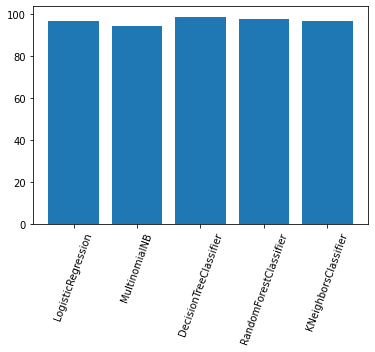

In [75]:
plt.bar(cls_name, accuracy)
plt.xticks(rotation=70)

DecisionTreeClassifier is the best classifier with 98.73% accuracy

In [128]:
# Save to csv

lg_model = DecisionTreeClassifier().fit(train_tfidf_model,train_df.sentiment)
lg_lbl_pred = model.predict(test_tfidf_model)

In [77]:
lg_lbl_pred_df = pd.DataFrame({'tweet_id': test_df.tweet_id,
                            'text' : test_df.nonstop_documents,
                            'lg_reg' : lg_lbl_pred})
lg_lbl_pred_df.head()

,tweet_id,text,lg_reg
1412,1327725448273522688,greeting kindly provide u booking reference p...,Positive
985,1322637029822337027,dear guest information travel guideline requi...,Positive
432,1328395406150078470,dear guest please review saudia website fligh...,Neutral
964,1322732128900124672,dear guest flight india saudi arabia time kin...,Positive
1169,1321438810673238016,dear guest kindly check flight schedule choos...,Positive


In [78]:
lg_lbl_pred_df.to_csv('airline_prediction.csv')
!cp airline_prediction.csv "./gdrive/My Drive/datasets/twitter_analysis/"

#ROC
Sensitivity/Specificity from ROC Curve: The Sensitivity is basically the same as recall and tells us the True Positive Rate.

In [113]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [121]:
lg_model = DecisionTreeClassifier().fit(train_tfidf_model,train_df.sentiment)


In [130]:
lg_lbl_pred = model.predict(test_tfidf_model)

In [131]:
probs = model.predict_proba(test_tfidf_model)

In [132]:
probs = probs[:, 1]

In [135]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(test_tfidf_model, probs)
print('AUC: %.2f' % auc)

TypeError: ignored

#make the airline is the target

In [142]:
lbl_actual = test_df.airline
i = 0
accuracy = []
for cl in cls:
    model = cl.fit(train_tfidf_model,train_df.airline)
    lbl_pred = model.predict(test_tfidf_model)
    a = (100*accuracy_score(lbl_pred, lbl_actual))
    a = round(a,2)
    accuracy.append(a)
    cls_name.append(cl.__class__.__name__)
    print ("{}  Accuracy Score : {}%".format(cls_name[i],a))
    print ( classification_report(lbl_pred, lbl_actual))
    i +=1

LogisticRegression  Accuracy Score : 98.73%
                precision    recall  f1-score   support

Saudi_airlines       1.00      0.99      0.99       417
        flynas       0.90      1.00      0.95        54

      accuracy                           0.99       471
     macro avg       0.95      0.99      0.97       471
  weighted avg       0.99      0.99      0.99       471

MultinomialNB  Accuracy Score : 97.88%
                precision    recall  f1-score   support

Saudi_airlines       1.00      0.98      0.99       419
        flynas       0.85      0.98      0.91        52

      accuracy                           0.98       471
     macro avg       0.92      0.98      0.95       471
  weighted avg       0.98      0.98      0.98       471

DecisionTreeClassifier  Accuracy Score : 99.36%
                precision    recall  f1-score   support

Saudi_airlines       1.00      1.00      1.00       410
        flynas       0.98      0.97      0.98        61

      accuracy       

([0, 1, 2, 3, 4], <a list of 5 Text major ticklabel objects>)

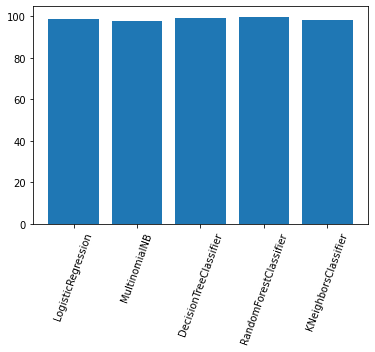

In [143]:
plt.bar(cls_name, accuracy)
plt.xticks(rotation=70)

RandomForestClassifier predicts the airline with 99.79% accuracy